# Validation Analysis - Figures

In [1]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
SAVE_FIGS = False
REPO_ROOT = '/Users/rwegener/repos/chesapeake_mhw'

In [3]:
# MUR and Geopolar anomaly compared to in situ anomaly
# wq_sst = pd.read_csv('../data/AllTemps_SSTAnomaly.csv')
# 'Anomaly_values_satellite_cbp.csv'
path = os.path.join(REPO_ROOT, 'data/processed', 'raw_values_satellites_CBPstations_filtered.csv')
wq_sst = pd.read_csv(path, parse_dates=[3])

In [4]:
wq_sst.geopolar = wq_sst.geopolar- 273.15
wq_sst.mur = wq_sst.mur- 273.15
wq_sst.ostia = wq_sst.ostia- 273.15

In [5]:
wq_sst

MeasureValue  Latitude  Longitude SampleDate   geopolar  mur  ostia
0               8.3   38.4000   -77.3200 2007-03-22   3.999994  NaN   2.97
1              26.2   38.4000   -77.3200 2007-06-18  21.969995  NaN  20.51
2              14.5   38.4000   -77.3200 2007-10-29  18.019983  NaN  17.01
3               5.2   38.4000   -77.3200 2007-12-10  10.749994  NaN  11.37
4               4.9   38.4000   -77.3200 2008-02-04   3.670007  NaN   4.00
...             ...       ...        ...        ...        ...  ...    ...
51139          27.7   38.9362   -76.5067 2004-07-08        NaN  NaN    NaN
51140          29.0   38.9362   -76.5067 2004-08-05        NaN  NaN    NaN
51141          26.4   38.9362   -76.5067 2004-08-19        NaN  NaN    NaN
51142          24.5   38.9362   -76.5067 2004-09-15        NaN  NaN    NaN
51143          17.0   38.9362   -76.5067 2004-10-13        NaN  NaN    NaN

[51144 rows x 7 columns]

## Pre-processing

In [18]:
wq_sst['geopolar_err'] = wq_sst['geopolar'] - wq_sst['MeasureValue']
wq_sst['mur_err'] = wq_sst['mur'] - wq_sst['MeasureValue']
wq_sst['ostia_err'] = wq_sst['ostia'] - wq_sst['MeasureValue']

In [9]:
mur_nonan = wq_sst[~wq_sst['mur'].isnull()][['MeasureValue', 'mur']]
geop_nonan = wq_sst[~wq_sst['geopolar'].isnull()][['MeasureValue', 'geopolar']]
ostia_nonan = wq_sst[~wq_sst['ostia'].isnull()][['MeasureValue', 'ostia']]

## Compute Mean Bias

In [21]:
def compute_mean_bias(error_series, name='no_name_given'):
    err = error_series.dropna()
    mean_bias = err.sum() / len(err)
    print('Mean bias of', name, 'is: ', np.round(mean_bias, 4))
    return mean_bias

In [23]:
geopolar_anom = compute_mean_bias(wq_sst.geopolar_err, 'geopolar')
mur_anom = compute_mean_bias(wq_sst.mur_err, 'MUR')
ostia_anom = compute_mean_bias(wq_sst.ostia_err, 'OSTIA')

Mean bias of geopolar is:  -0.5211
Mean bias of MUR is:  -0.5413
Mean bias of OSTIA is:  -0.5221


In [8]:
# ostia_anom = (wq_sst.ostia - wq_sst.MeasureValue).dropna()
# print('OSTIA mean bias is', ostia_anom.sum() / len(ostia_anom))

## Compute $R^2$

In [84]:
slope, inter, r_val, p_val, std_err = scipy.stats.linregress(
    mur_nonan.MeasureValue, mur_nonan.mur)

print('MUR: r squared', r_val**2)

MUR: r squared 0.953601160726013


In [10]:
slope, inter, r_val, p_val, std_err = scipy.stats.linregress(
    geop_nonan.MeasureValue, geop_nonan.geopolar)

print('GEOPOLAR: r squared', r_val**2)

GEOPOLAR: r squared 0.964755180126079


In [11]:
slope, inter, r_val, p_val, std_err = scipy.stats.linregress(
    ostia_nonan.MeasureValue, ostia_nonan.ostia)

print('OSTIA: r squared', r_val**2)

OSTIA: r squared 0.9629621138226688


## Computing slope and $R^2$ values with robust regression

[https://www.statsmodels.org/stable/rlm.html](https://www.statsmodels.org/stable/rlm.html)

References:
- SO [example](https://stackoverflow.com/questions/46606082/using-huber-scale-and-location-estimator-in-statsmodel)
- Penn State [course webpage](https://online.stat.psu.edu/stat501/lesson/t/t.1/t.1.1-robust-regression-methods)
- statsmodels [RLMdocs](https://www.statsmodels.org/stable/generated/statsmodels.robust.robust_linear_model.RLM.html)
- [graphs](https://www.statsmodels.org/stable/rlm_techn1.html) for the weight function
- SO [post](https://stackoverflow.com/questions/31655196/how-to-get-r-squared-for-robust-regression-rlm-in-statsmodels) arguing against R2 when using robust regression

In [12]:
def robust_regression(x_values, y_values):
    model = sm.RLM(y_values, sm.add_constant(x_values), 
                   M=sm.robust.norms.TukeyBiweight())
    results = model.fit()
    rlm_slope = results.params.MeasureValue
    rlm_inter = results.params.const
    print('slope', np.round(rlm_slope, 4), 
          'and intercept', np.round(rlm_inter, 4))
    return rlm_slope, rlm_inter

### MUR

In [13]:
mur_slope, mur_inter = robust_regression(mur_nonan.MeasureValue, mur_nonan.mur)

slope 0.9817 and intercept 0.1451


In [35]:
# mur_model = sm.RLM(y_mur, sm.add_constant(x_mur), M=sm.robust.norms.TukeyBiweight())
# mur_results = mur_model.fit()
# rlm_slope_mur = mur_results.params.MeasureValue
# rlm_inter_mur = mur_results.params.const
# print('MUR slope', rlm_slope_mur, 'and intercept', rlm_inter_mur)

MUR slope 0.9816546679564828 and intercept 0.14506944536215863


### Geo-Polar

In [75]:
geopolar_slope, geopolar_inter = robust_regression(
    geop_nonan.MeasureValue, geop_nonan.geopolar)

slope 0.9742 and intercept 0.1498


### OSTIA

In [15]:
ostia_slope, ostia_inter = robust_regression(
    ostia_nonan.MeasureValue, ostia_nonan.ostia)

slope 0.9715 and intercept 0.231


## Compute RMSE

In [43]:
def compute_rmse(error_series, name='no_name_given'):
    rmse = np.sqrt((error_series**2).sum() / error_series.count())
    print('RMSE', name, ':', np.round(rmse, 4))
    return rmse

In [44]:
gepolar_rmse = compute_rmse(wq_sst.geopolar_err, 'Geo-Polar')
mur_rmse = compute_rmse(wq_sst.mur_err, 'MUR')
ostia_rmse = compute_rmse(wq_sst.ostia_err, 'OSTIA')

RMSE Geo-Polar : 1.6052
RMSE MUR : 1.8495
RMSE OSTIA : 1.6408


In [24]:
# # Compute and print Geo-Polar RMSE
# N = len(wq_sst[~wq_sst['geopolar_err'].isnull()])

# rmse_geopolar = np.sqrt((wq_sst['geopolar_err']**2).sum() / N)
# print('RMSE Geo-Polar: ', rmse_geopolar)

# # Compute and print MUR RMSE
# N = len(wq_sst[~wq_sst['mur_err'].isnull()])

# rmse_mur = np.sqrt((wq_sst['mur_err']**2).sum() / N)
# print('RMSE MUR: ', rmse_mur)

# # Compute and print OSTIA RMSE
# N = len(wq_sst[~wq_sst['ostia_err'].isnull()])

# rmse_ostia = np.sqrt((wq_sst['ostia_err']**2).sum() / N)
# print('RMSE OSTIA: ', rmse_ostia)

RMSE Geo-Polar:  1.6052077365877537
RMSE MUR:  1.849483193868846
RMSE OSTIA:  1.6407760552518724


## Hexbin plots for distribution

In [71]:
def mx_plus_b(x, slope, intercept):
    return slope * x + intercept

In [51]:
# This would work if I could install pandas>=2.0
# wq_sst[['geopolar', 'mur', 'ostia']].max(axis=None)

/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_778/2333454139.py:1: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  wq_sst[['geopolar', 'mur', 'ostia']].max(axis=None)


geopolar    30.489984
mur         30.967004
ostia       30.660000
dtype: float64

In [ ]:
wq_sst['geopolar']

This shorter method should work so long as there aren't any rows that have nan for all three satellites (shouldn't this get removed in an earlier notebook?)

In [57]:
ymax = wq_sst[['geopolar', 'mur', 'ostia']].max().max()
ymin = wq_sst[['geopolar', 'mur', 'ostia']].min().min()



In [56]:
xmax = wq_sst.MeasureValue.max()
xmin = wq_sst.MeasureValue.min()

In [58]:
print(xmin, xmax, ymin, ymax)

-0.8 45.0 -1.7999938964843523 30.967004394531273


In [63]:
x_geop = geop_nonan.MeasureValue
y_geop = geop_nonan.geopolar

x_mur = mur_nonan.MeasureValue
y_mur = mur_nonan.mur

x_ostia = ostia_nonan.MeasureValue
y_ostia = ostia_nonan.ostia

In [69]:
# Find min and max values to set axis extents
xmin, xmax = pd.concat([x_geop, x_mur, x_ostia]).min(), pd.concat([x_geop, x_mur, x_ostia]).max()
ymin, ymax = pd.concat([y_geop, y_mur, y_ostia]).min(), pd.concat([y_geop, y_mur, y_ostia]).max()
print(xmin, xmax, ymin, ymax)

-0.8 32.2 -1.7999938964843523 30.967004394531273


In [76]:
# gridspec = {'width_ratios': [1.5, 1.5, 0.1]}
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw=gridspec)
# fig.suptitle('Satellite vs. In Situ Temperature Measurements', size=16)

# bbox_props = {'boxstyle': 'round', 'facecolor': 'white',
#              'pad': 0.5, 'edgecolor': 'green'}

# mur_plot = ax1.hexbin(x_mur, y_mur, gridsize=30, bins='log', cmap='inferno', 
#                       extent=(xmin, xmax, ymin, ymax)) # mincnt=1)
# ax1.plot([-3, 32], [mx_plus_b(-3, rlm_slope_mur, rlm_inter_mur), 
#                      mx_plus_b(32, rlm_slope_mur, rlm_inter_mur)], 
#          color='green', label='best fit', linewidth=1)
# ax1.set_ylabel('MUR Temperature ($\Delta^oC$)')
# ax1.set_title('MUR vs. In situ Temperature', size=14)
# ax1.text(-10, -13, 'y = {m}x + {b}'.format(m=rlm_slope_mur.round(3), 
#                                     b=rlm_inter_mur.round(3)), bbox=bbox_props)


# geop_plot = ax2.hexbin(x_geop, y_geop, gridsize=30, bins='log', cmap='inferno',
#                       extent=(xmin, xmax, ymin, ymax))  # , mincnt=1)
# # plot the line of linear fit
# # ax2.plot([-8, 8], [mx_plus_b(-8, gp_slope, gp_intercept), 
# #                      mx_plus_b(8, gp_slope, gp_intercept)], 
# #          color='green', label='linear fit', linewidth=0.8)
# ax2.plot([-3, 32], [mx_plus_b(-3, rlm_slope_geop, rlm_inter_geop), 
#                      mx_plus_b(32, rlm_slope_geop, rlm_inter_geop)], 
#          color='green', label='best fit', linewidth=1)
# ax2.set_ylabel('Geo-Polar Temperature ($\Delta^oC$)')
# ax2.set_title('Geo-Polar vs. In situ Temperature', size=14)
# ax2.text(-10, -13, 'y = {m}x + {b}'.format(m=rlm_slope_geop.round(3), 
#                                     b=rlm_inter_geop.round(3)), bbox=bbox_props)


# # Standardize axes settings
# for ax in (ax1, ax2):
#     # plot and label the 1:1 line
#     # ax.plot([-10, 10], [-10, 10], color='blue', label='1:1 line', linewidth=0.8)
#     ax.legend(loc="upper left")
#     # label the x axis
#     ax.set_xlabel('In situ Temperature ($\Delta^oC$)')
#     ax.minorticks_on()
#     # add gridlines
#     ax.set_axisbelow(True)
#     ax.grid(linestyle='--', linewidth=0.8)

# # Add shared colorbar
# cb = fig.colorbar(geop_plot, cax=ax3)
# cb.set_label('Number of observations')

# # Turn back on for SST Values
# fig.tight_layout()

# if SAVE_FIGS:
#     plt.savefig(os.path.join(REPO_ROOT, 'figures/validation_analysis/satellite_validation_raw_hexplot.jpeg'), 
#                 bbox_inches='tight', dpi=700)


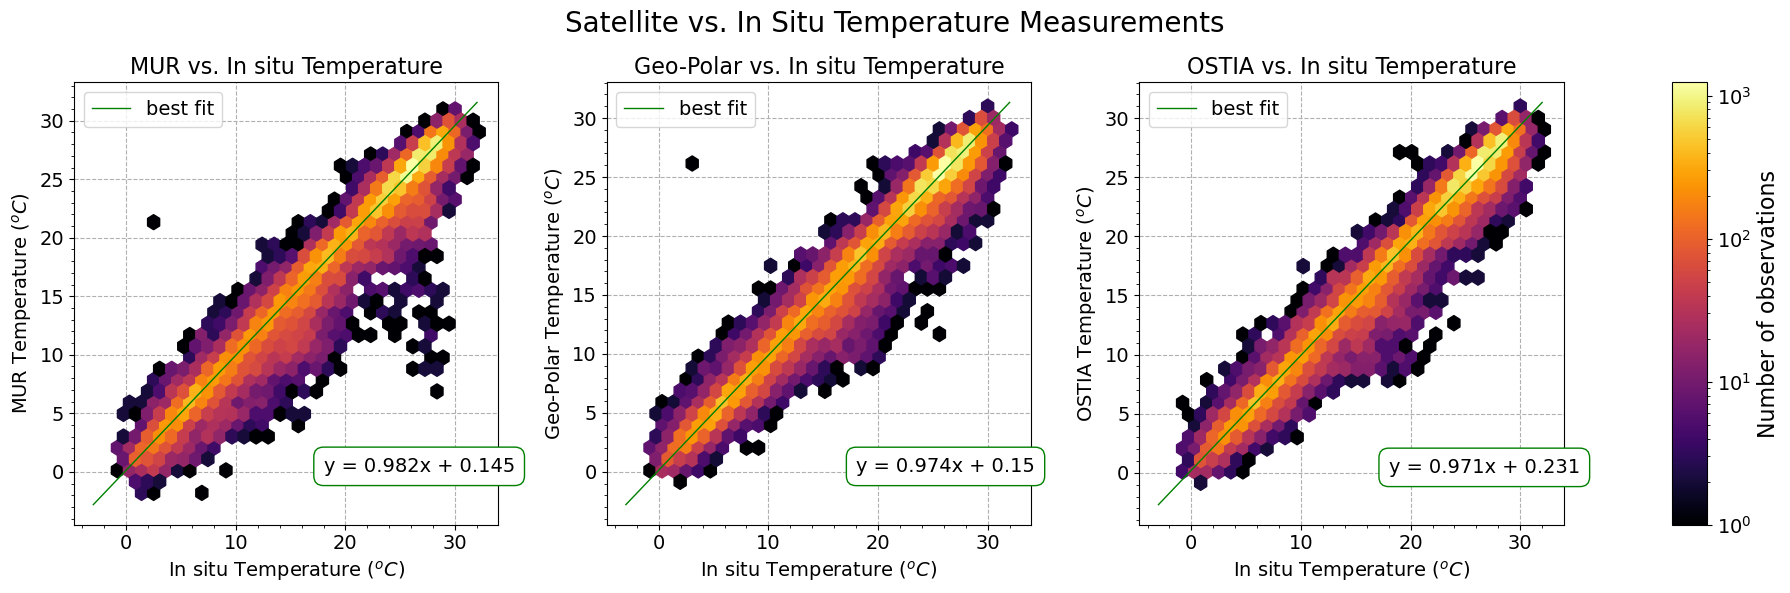

In [79]:
# Create a plot with 3 grids for the data and one grid for the colorbar
gridspec = {'width_ratios': [1.2, 1.2, 1.2, 0.1]}
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw=gridspec)
fig.suptitle('Satellite vs. In Situ Temperature Measurements', size=20)

# Set properties for box around line of best fit
bbox_props = {'boxstyle': 'round', 'facecolor': 'white', 'pad': 0.5, 
              'edgecolor': 'green'}

# Add MUR heatmap
mur_plot = ax1.hexbin(x_mur, y_mur, gridsize=30, bins='log', cmap='inferno', 
                      extent=(xmin, xmax, ymin, ymax))
# Add MUR best fit line
ax1.plot([-3, 32], [mx_plus_b(-3, mur_slope, mur_inter), 
                     mx_plus_b(32, mur_slope, mur_inter)], 
         color='green', label='best fit', linewidth=1)
ax1.set_ylabel('MUR Temperature ($^oC$)', fontsize=14)
ax1.set_title('MUR vs. In situ Temperature', size=16)
ax1.text(18, 0, 'y = {m}x + {b}'.format(m=mur_slope.round(3), 
                                    b=mur_inter.round(3)), bbox=bbox_props,
                                    fontdict={'fontsize': 14})

# Add Geo-Polar heatmap
geop_plot = ax2.hexbin(x_geop, y_geop, gridsize=30, bins='log', cmap='inferno',
                      extent=(xmin, xmax, ymin, ymax))
# Add Geo-Polar best fit line
ax2.plot([-3, 32], [mx_plus_b(-3, geopolar_slope, geopolar_inter), 
                     mx_plus_b(32, geopolar_slope, geopolar_inter)], 
         color='green', label='best fit', linewidth=1)
ax2.set_ylabel('Geo-Polar Temperature ($^oC$)', fontsize=14)
ax2.set_title('Geo-Polar vs. In situ Temperature', fontsize=16)
ax2.text(18, 0, 'y = {m}x + {b}'.format(m=geopolar_slope.round(3), 
                                    b=geopolar_inter.round(3)), bbox=bbox_props,
                                        fontdict={'fontsize': 14})

# Add OSTIA heatmap
ost_plot = ax3.hexbin(x_ostia, y_ostia, gridsize=30, bins='log', cmap='inferno',
                      extent=(xmin, xmax, ymin, ymax))
# Add OSTIA best fit line
ax3.plot([-3, 32], [mx_plus_b(-3, ostia_slope, ostia_inter), 
                     mx_plus_b(32, ostia_slope, ostia_inter)], 
         color='green', label='best fit', linewidth=1)
ax3.set_ylabel('OSTIA Temperature ($^oC$)', fontsize=14)
ax3.set_title('OSTIA vs. In situ Temperature', size=16)
ax3.text(18, 0, 'y = {m}x + {b}'.format(m=ostia_slope.round(3), 
                                    b=ostia_inter.round(3)), bbox=bbox_props,
                                    fontdict={'fontsize': 14})


# Standardize axes settings
for ax in (ax1, ax2, ax3):
    ax.legend(loc="upper left", fontsize=14)
    # label the x axis
    ax.set_xlabel('In situ Temperature ($^oC$)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.minorticks_on()
    # add gridlines
    ax.set_axisbelow(True)
    ax.grid(linestyle='--', linewidth=0.8)

# Add shared colorbar
cb = fig.colorbar(geop_plot, cax=ax4)
cb.set_label('Number of observations', fontsize=16)
cb.ax.tick_params(labelsize=14)

# Turn back on for SST Values
fig.tight_layout()

if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures/validation_analysis/satellite_validation_raw_hexplot.jpeg'), 
                bbox_inches='tight', dpi=700)


## Spatial Distribution of Error

Create geodataframe with average values at each location

**maybe keep station id to this point instead, so that can be used to group on here?**

In [102]:
wq_sst.Latitude = wq_sst.Latitude.round(1)
wq_sst.Longitude = wq_sst.Longitude.round(1)

In [103]:
wq_sst

MeasureValue  Latitude  Longitude SampleDate   geopolar  mur  ostia  \
0               8.3      38.4      -77.3 2007-03-22   3.999994  NaN   2.97   
1              26.2      38.4      -77.3 2007-06-18  21.969995  NaN  20.51   
2              14.5      38.4      -77.3 2007-10-29  18.019983  NaN  17.01   
3               5.2      38.4      -77.3 2007-12-10  10.749994  NaN  11.37   
4               4.9      38.4      -77.3 2008-02-04   3.670007  NaN   4.00   
...             ...       ...        ...        ...        ...  ...    ...   
51139          27.7      38.9      -76.5 2004-07-08        NaN  NaN    NaN   
51140          29.0      38.9      -76.5 2004-08-05        NaN  NaN    NaN   
51141          26.4      38.9      -76.5 2004-08-19        NaN  NaN    NaN   
51142          24.5      38.9      -76.5 2004-09-15        NaN  NaN    NaN   
51143          17.0      38.9      -76.5 2004-10-13        NaN  NaN    NaN   

       geopolar_err  mur_err  ostia_err  
0         -4.300006      NaN      -5.33  
1         -4.230005      NaN      -5.69  
2          3.519983      NaN       2.51  
3          5.549994      NaN       6.17  
4         -1.229993      NaN      -0.90  
...             ...      ...        ...  
51139           NaN      NaN        NaN  
51140           NaN      NaN        NaN  
51141           NaN      NaN        NaN  
51142           NaN      NaN        NaN  
51143           NaN      NaN        NaN  

[51144 rows x 10 columns]

In [104]:
temps_mean = wq_sst.groupby(['Latitude', 'Longitude']) \
        .mean(numeric_only=True).reset_index()

In [105]:
temps_mean_gpd = gpd.GeoDataFrame(
    temps_mean, geometry=gpd.points_from_xy(
        temps_mean['Longitude'], temps_mean['Latitude']
    ), 
    crs='epsg:4326'
)

In [106]:
len(temps_mean_gpd)

264

In [98]:
# rounding lat/lon to 2 decimal points
len(temps_mean_gpd)

680

In [95]:
# old number of points (no rounding)
len(temps_mean_gpd)

724

In [107]:
temps_mean_gpd.sort_values(['Latitude', 'Longitude']).diff().sort_values(['Latitude', 'Longitude'])

/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_778/3311898749.py:1: FutureWarning: dtype lost in 'diff()'. In the future this will raise a TypeError. Convert to a suitable dtype prior to calling 'diff'.
  temps_mean_gpd.sort_values(['Latitude', 'Longitude']).diff().sort_values(['Latitude', 'Longitude'])


Latitude  Longitude  MeasureValue  geopolar       mur     ostia  \
2         0.0        0.1     -0.049707       NaN       NaN       NaN   
4         0.0        0.1      2.924918  2.631872  2.688224  2.734011   
6         0.0        0.1     -0.397360 -1.377253       NaN -1.397684   
8         0.0        0.1     -1.064769 -0.876268 -0.592664 -0.804257   
10        0.0        0.1     -0.300025 -0.042237 -1.486190  0.080803   
..        ...        ...           ...       ...       ...       ...   
12        0.1       -0.6     -0.169143 -0.332835 -0.957978 -0.659029   
7         0.1       -0.5     -1.391146  0.282375       NaN -0.089477   
209       0.1       -0.4     -0.071415       NaN -1.339115       NaN   
3         0.1       -0.1     -0.980994       NaN       NaN       NaN   
0         NaN        NaN           NaN       NaN       NaN       NaN   

     geopolar_err   mur_err  ostia_err                    geometry  
2             NaN       NaN        NaN  POINT (-76.20000 36.80000)  
4       -0.498994 -0.100121  -0.331224  POINT (-76.20000 36.90000)  
6       -1.035197       NaN  -1.000324  POINT (-76.00000 36.90000)  
8        0.180958  0.275058   0.270291  POINT (-76.40000 37.00000)  
10       0.257788  0.028960   0.284041  POINT (-76.20000 37.00000)  
..            ...       ...        ...                         ...  
12      -0.282708 -0.788835  -0.409214  POINT (-76.60000 37.10000)  
7        1.575341       NaN   1.412525  POINT (-76.50000 37.00000)  
209           NaN -0.437383        NaN  POINT (-76.60000 39.00000)  
3             NaN       NaN        NaN  POINT (-76.30000 36.90000)  
0             NaN       NaN        NaN                        None  

[264 rows x 10 columns]

Plot

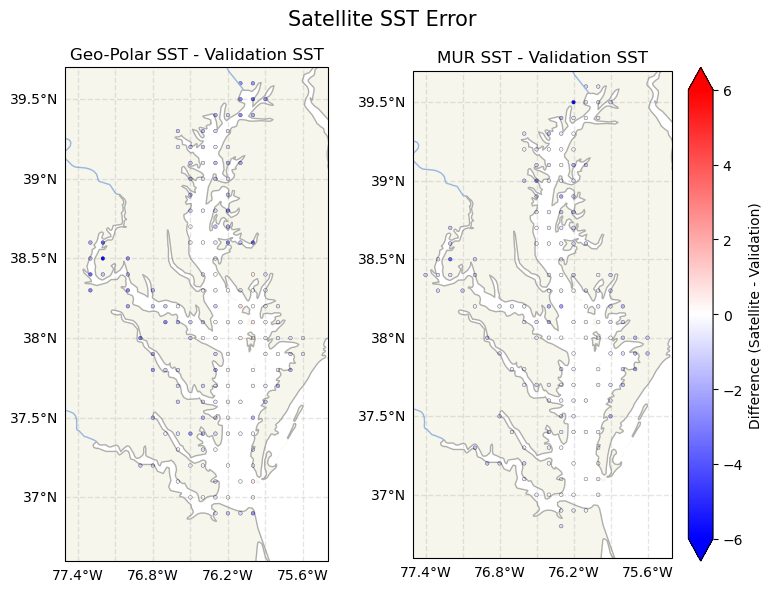

In [108]:
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(8, 6)

for ax in axes:
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

# Add Geo-Polar mean error
temps_mean_gpd.plot(ax=axes[0], column='geopolar_err', markersize=7, cmap='bwr',
                    vmin=-4, vmax=4, edgecolor='black', linewidth=0.2)
axes[0].set_title('Geo-Polar SST - Validation SST', size=12)

# Add MURR mean error
temps_mean_gpd.plot(ax=axes[1], column='mur_err', markersize=7, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Difference (Satellite - Validation)", 
                                 'extend': 'both'}, 
                    vmin=-6, vmax=6, edgecolor='black', linewidth=0.2)
axes[1].set_title('MUR SST - Validation SST', size=12)

fig.suptitle('Satellite SST Error', size=15, ha='center')

plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/sst_error_spatial_distribution.png'), 
                dpi=700, bbox_inches='tight')

Adding OSTIA

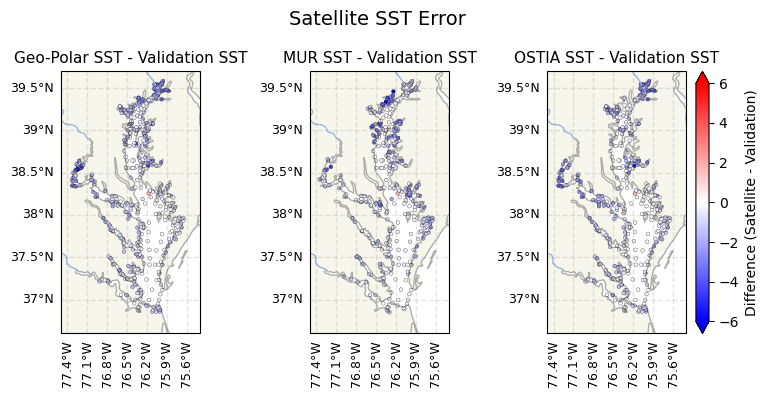

In [49]:
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(8, 6)

for ax in axes:
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False
    gl.xlabel_style = {'size': 9, 'rotation': 90}
    gl.ylabel_style = {'size': 9}

# Add Geo-Polar mean error
temps_mean_gpd.plot(ax=axes[0], column='geopolar_diff', markersize=7, cmap='bwr', # legend=True, 
                    # legend_kwds={'label': "Difference (Satellite - Validation)", 
                    #              'extend': 'both'}, 
                    vmin=-6, vmax=6, edgecolor='black', linewidth=0.2)
axes[0].set_title('Geo-Polar SST - Validation SST', size=11)

# Add MUR mean error
temps_mean_gpd.plot(ax=axes[1], column='mur_diff', markersize=7, cmap='bwr', # legend=True, 
                    # legend_kwds={'label': "Difference (Satellite - Validation)", 
                    #              'extend': 'both'}, 
                    vmin=-6, vmax=6, edgecolor='black', linewidth=0.2)
axes[1].set_title('MUR SST - Validation SST', size=11)

# Add OSTIA mean error
temps_mean_gpd.plot(ax=axes[2], column='ostia_diff', markersize=7, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Difference (Satellite - Validation)", 
                                 'extend': 'both'}, 
                    vmin=-6, vmax=6, edgecolor='black', linewidth=0.2)
axes[2].set_title('OSTIA SST - Validation SST', size=11)

fig.suptitle('Satellite SST Error', size=14, ha='center')

plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/sst_error_spatial_distribution.png'), 
                dpi=700, bbox_inches='tight')

AttributeError: 'GeoAxesSubplot' object has no attribute 'get_array'

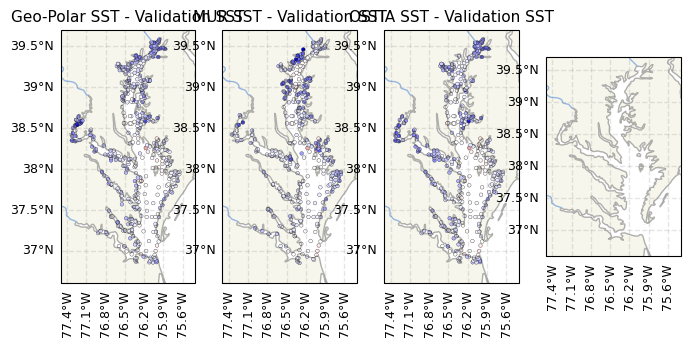

In [95]:
# gridspec = {'width_ratios': [1.2, 1.2, 1.2, 0.1]}
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 6), gridspec_kw=gridspec)
# fig.suptitle('Satellite vs. In Situ Temperature Measurements', size=20)


fig, axes = plt.subplots(1, 4, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(8, 4)
# fig.tight_layout()
# plt.title('Satellite Anomaly Error Spatial Distribution', size=15)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

for ax in axes:
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False
    gl.xlabel_style = {'size': 9, 'rotation': 90}
    gl.ylabel_style = {'size': 9}

# Add Geo-Polar mean error
geop_plot = temps_mean_gpd.plot(ax=ax1, column='geopolar_diff', markersize=7, cmap='bwr', # legend=True, 
                    # legend_kwds={'label': "Difference (Satellite - Validation)", 
                    #              'extend': 'both'}, 
                    vmin=-6, vmax=6, edgecolor='black', linewidth=0.2)
ax1.set_title('Geo-Polar SST - Validation SST', size=11)

# Add MUR mean error
temps_mean_gpd.plot(ax=ax2, column='mur_diff', markersize=7, cmap='bwr', # legend=True, 
                    # legend_kwds={'label': "Difference (Satellite - Validation)", 
                    #              'extend': 'both'}, 
                    vmin=-6, vmax=6, edgecolor='black', linewidth=0.2)
ax2.set_title('MUR SST - Validation SST', size=11)

# Add OSTIA mean error
temps_mean_gpd.plot(ax=ax3, column='ostia_diff', markersize=7, cmap='bwr', # legend=True, 
                    # legend_kwds={'label': "Difference (Satellite - Validation)", 
                    #              'extend': 'both'}, 
                    vmin=-6, vmax=6, edgecolor='black', linewidth=0.2)
ax3.set_title('OSTIA SST - Validation SST', size=11)


# Add shared colorbar
cb = fig.colorbar(geop_plot, cax=ax4)
cb.set_label('Difference (Satellite - Validation)', fontsize=16)
cb.ax.tick_params(labelsize=14)


fig.suptitle('Satellite SST Error', size=14, ha='center')

plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/sst_error_spatial_distribution.png'), 
                dpi=700, bbox_inches='tight')

## Long term trend in error

In [46]:
def get_slope(df):
    '''
    Slope of the long term trend in geopolar error.
    Units unknown a.t.m.
    '''
    # print(len(df))
    x = df.SampleDate.apply(lambda x: x.toordinal())
    y = df.geopolar_diff
    # Slope of long term trend
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    # Multiply by 365 so units are degrees / year not degrees / day
    df['slope'] = slope * 365
    if p_value >= 0.05:
        df['slope'] = np.nan
    # Mean
    df['mean'] = df.geopolar_diff.mean()
    # STD
    df['std'] = df.geopolar_diff.std()
    # Skew
    df['skew'] = scipy.stats.skew(df.geopolar_diff)
    # kurtosis
    df['kurt'] = scipy.stats.kurtosis(df.geopolar_diff)
    # 95th percentile
    df['95th'] = df.geopolar_diff.quantile(0.95)
    return df

In [47]:
slopes = wq_sst.groupby(['Latitude', 'Longitude'], group_keys=True).apply(get_slope)

/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_2795/377247510.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  df['skew'] = scipy.stats.skew(df.geopolar_diff)
/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm

In [49]:
stats_gpd = gpd.GeoDataFrame(
    slopes, geometry=gpd.points_from_xy(slopes.Longitude, slopes.Latitude), crs="EPSG:4326"
)

In [50]:
std = wq_sst.groupby(['Latitude', 'Longitude', wq_sst.SampleDate.dt.month]).std(numeric_only=True) \
.groupby(['Latitude', 'Longitude']).mean().reset_index()

In [51]:
std_gpd = gpd.GeoDataFrame(
    std, geometry=gpd.points_from_xy(std.Longitude, std.Latitude), crs="EPSG:4326"
)

In [52]:
print('Geopolar max/min:', temps_mean_gpd.geopolar_diff.max(), temps_mean_gpd.geopolar_diff.min(), 
     temps_mean_gpd.geopolar_diff.median(), temps_mean_gpd.geopolar_diff.std())
# print('MUR max/min:', temps_mean_gpd.mur_diff.max(), temps_mean_gpd.mur_diff.min(),
#      temps_mean_gpd.mur_diff.median(), temps_mean_gpd.mur_diff.std())

Geopolar max/min: 3.069982910156251 -5.091006469726564 -0.5726563038545498 0.9603613675457604


In [53]:
# vmin, vmax = -1, 1

In [54]:
# norm = matplotlib.colors.SymLogNorm(linthresh=1, vmin=-5, vmax=5, base=10)

<AxesSubplot: >

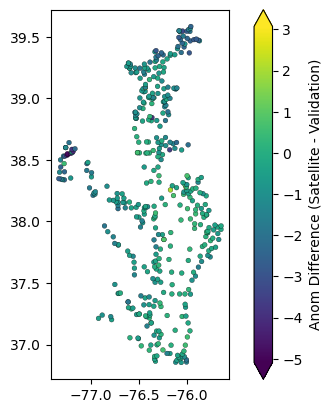

In [55]:
temps_mean_gpd.plot(column='geopolar_diff', markersize=12, legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 'extend': 'both'}, 
                    edgecolor='black', linewidth=0.2)

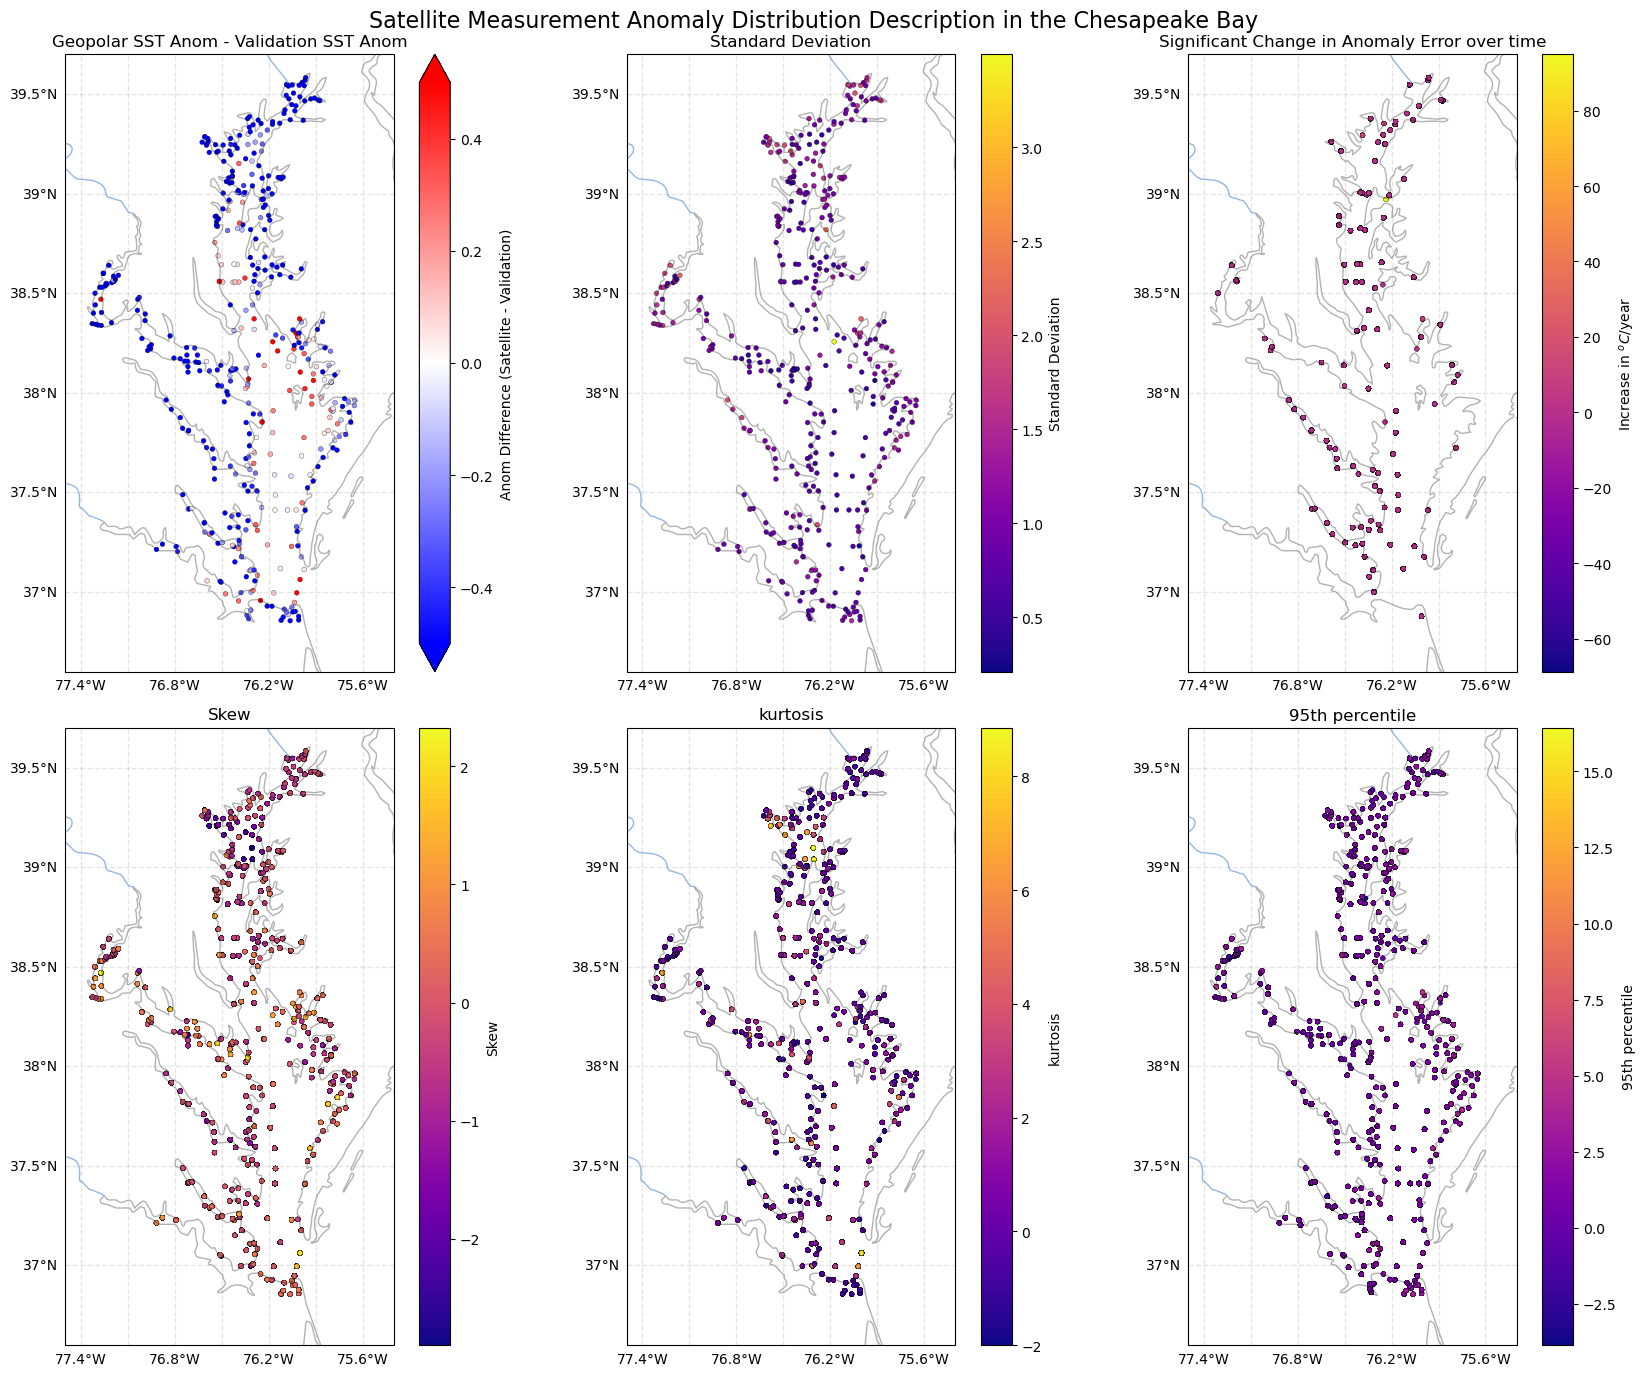

In [57]:
fig, axes = plt.subplots(2, 3, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(17, 14)
# fig.tight_layout()
fig.suptitle('Satellite Measurement Anomaly Distribution Description in the Chesapeake Bay', size=16)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

for ax in axes.flatten():
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)
    # ax.coastlines()

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

# Add mean error
temps_mean_gpd.plot(ax=axes[0, 0], column='geopolar_diff', markersize=12, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 'extend': 'both'}, 
                    vmin=-0.5, vmax=0.5, edgecolor='black', linewidth=0.2)
axes[0, 0].set_title('Geopolar SST Anom - Validation SST Anom', size=12)

# Standard Deviation
std_gpd.plot(ax=axes[0, 1], column='geopolar_diff', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Standard Deviation"}, 
                    edgecolor='black', linewidth=0.2)
axes[0, 1].set_title('Standard Deviation', size=12)

# Add long term trend slope
# Can't get pandas to show nan values. Maybe set to 0 then change colormap?
stats_gpd.plot(ax=axes[0, 2], column='slope', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Increase in $^oC$/year"}, 
                    edgecolor='black', linewidth=0.2)
axes[0, 2].set_title('Significant Change in Anomaly Error over time', size=12)


# Skew
stats_gpd.plot(ax=axes[1, 0], column='skew', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Skew"}, 
                    edgecolor='black', linewidth=0.2)
axes[1, 0].set_title('Skew', size=12)

# Kurtosis
stats_gpd.plot(ax=axes[1, 1], column='kurt', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "kurtosis"}, 
                    edgecolor='black', linewidth=0.2)
axes[1, 1].set_title('kurtosis', size=12)

# 95th Percentile
stats_gpd.plot(ax=axes[1, 2], column='95th', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "95th percentile"}, 
                    edgecolor='black', linewidth=0.2)
axes[1, 2].set_title('95th percentile', size=12)


plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/map_distribution_statistics.png'), 
                dpi=400, bbox_inches='tight')

Significant Time increases by spatial location

In [58]:
def trend_calc(df):
    '''
    When grouping by lat/long aggregate the anomalies by sorting in time and calculating
    returning True/False based on if there is a statistically significant change in 
    MeasureAnomaly over time
    '''
    df = df.sort_values('SampleDate')
    df = df[~df.geopolar_diff.isnull()]
    # print('IS NULL?', df.SampleDate.apply(lambda x: x.toordinal()))
    x = df.SampleDate.apply(lambda x: x.toordinal())
    y = df.geopolar_diff.values
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print(slope, intercept, r_value, p_value, std_err)
    plt.plot(x, y)
    plt.show()
    return slope

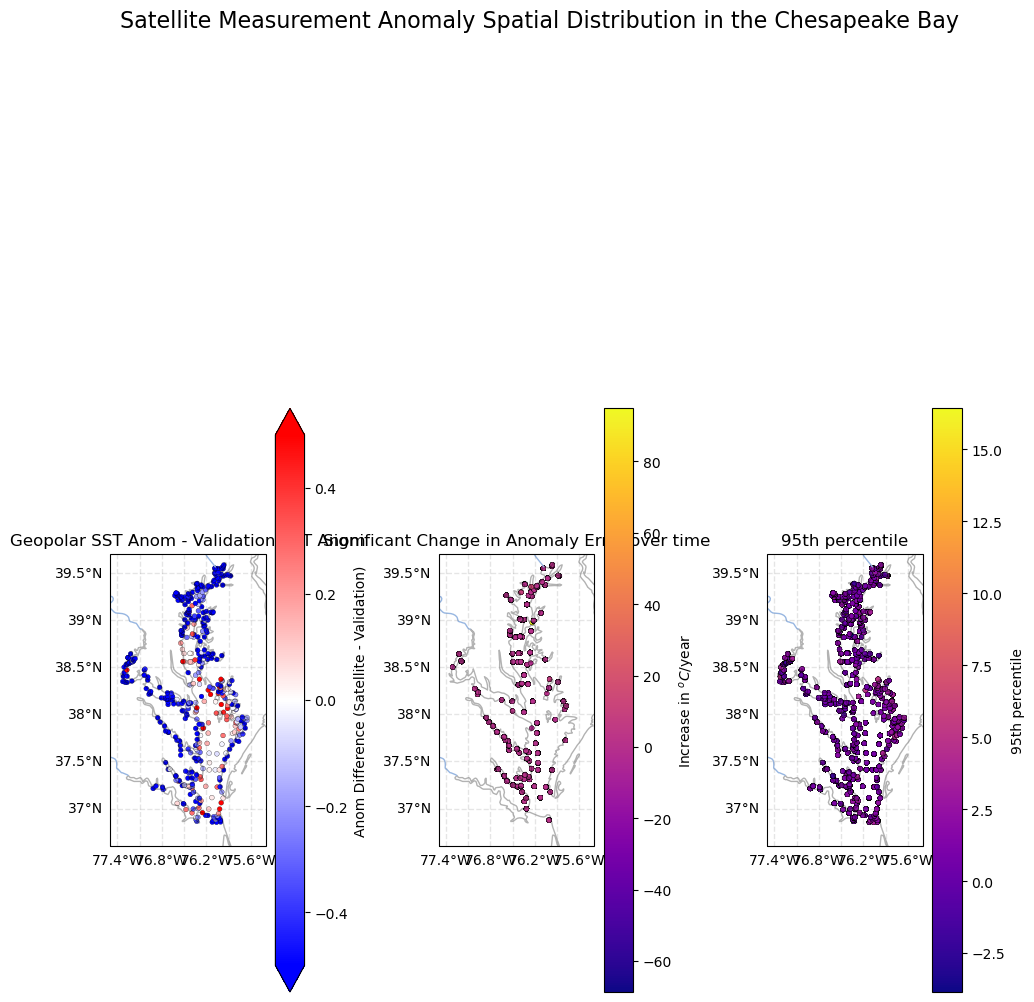

In [59]:
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(10, 14)
# fig.tight_layout()
fig.suptitle('Satellite Measurement Anomaly Spatial Distribution in the Chesapeake Bay', size=16)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

for ax in axes.flatten():
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False
    # ax.set_aspecxt('equal', 'box')

# Add mean error
temps_mean_gpd.plot(ax=axes[0], column='geopolar_diff', markersize=12, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 'extend': 'both'}, 
                    vmin=-0.5, vmax=0.5, edgecolor='black', linewidth=0.2)
axes[0].set_title('Geopolar SST Anom - Validation SST Anom', size=12)

# Add long term trend slope
# Can't get pandas to show nan values. Maybe set to 0 then change colormap?
stats_gpd.plot(ax=axes[1], column='slope', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Increase in $^oC$/year"}, 
                    edgecolor='black', linewidth=0.2)
axes[1].set_title('Significant Change in Anomaly Error over time', size=12)

# 95th Percentile
stats_gpd.plot(ax=axes[2], column='95th', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "95th percentile"}, 
                    edgecolor='black', linewidth=0.2)
axes[2].set_title('95th percentile', size=12)


plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/map_distribution_statistics.png'), 
                dpi=400, bbox_inches='tight')

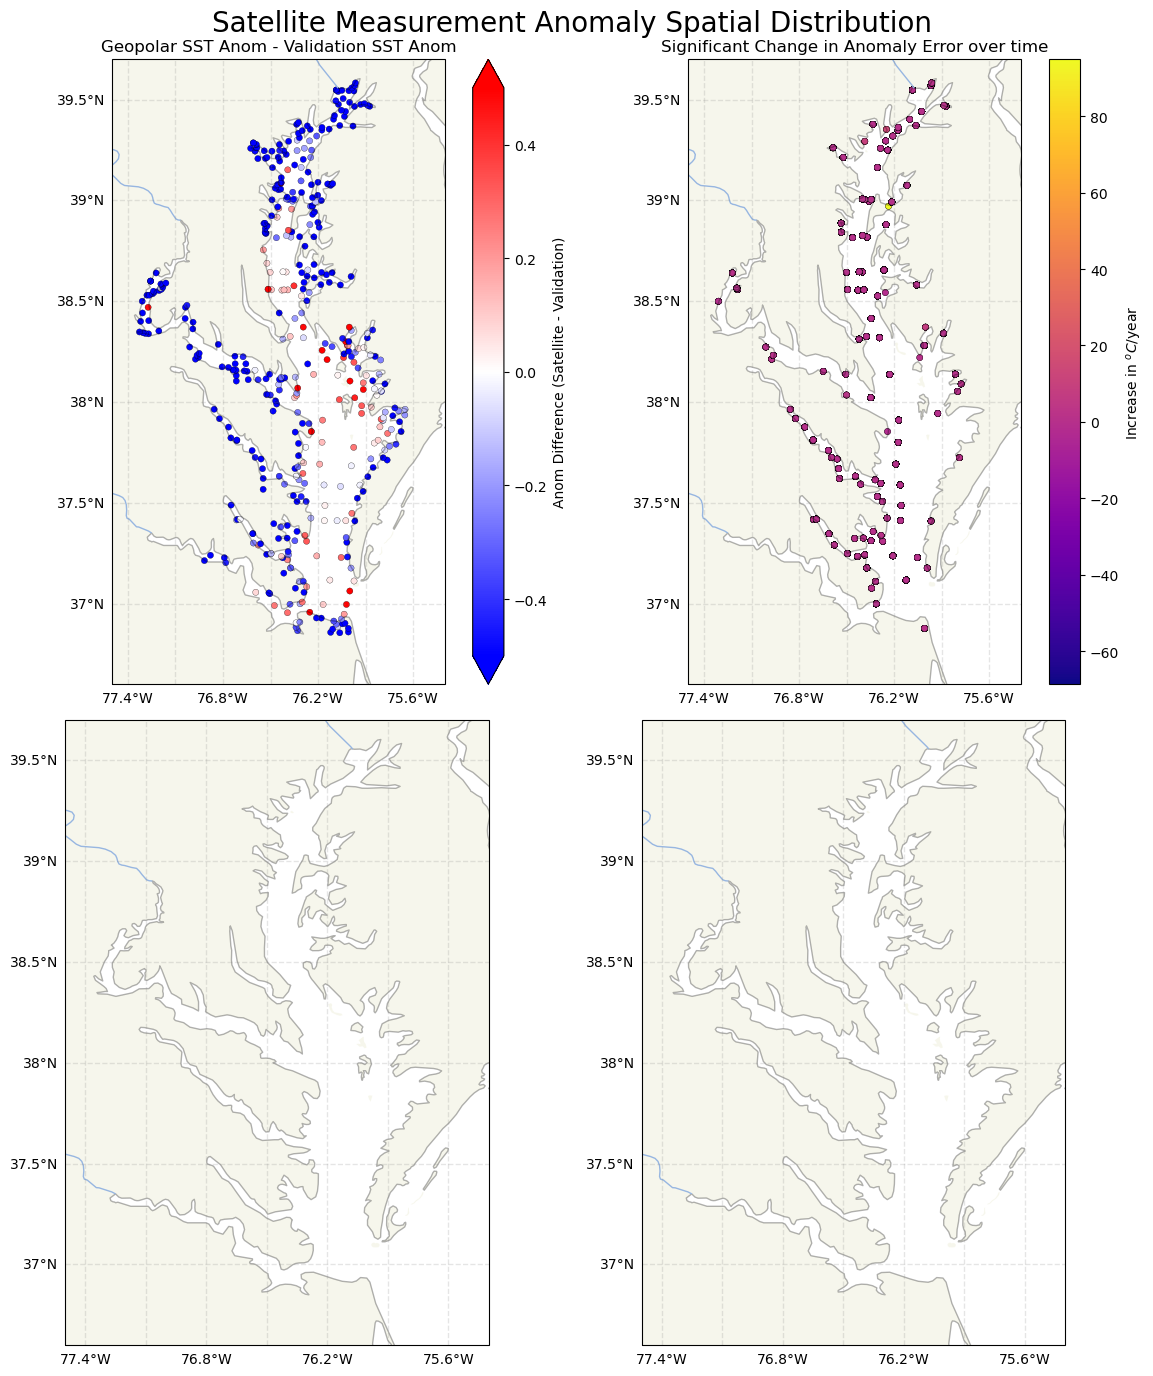

In [61]:
fig, axes = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(12, 14)
# fig.tight_layout()
fig.suptitle('Satellite Measurement Anomaly Spatial Distribution', size=20)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

for ax in axes.flatten():
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    # ax.coastlines()
    # Put a background image on for nice sea rendering.
    # ax.stock_img()

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

# Add mean error
temps_mean_gpd.plot(ax=axes[0, 0], column='geopolar_diff', markersize=20, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 'extend': 'both'}, 
                    vmin=-0.5, vmax=0.5, edgecolor='black', linewidth=0.2)
axes[0, 0].set_title('Geopolar SST Anom - Validation SST Anom', size=12)

# Standard Deviation
# std_gpd.plot(ax=axes[0, 1], column='geopolar_diff', markersize=12, cmap='plasma',
#                 legend=True,
#                     legend_kwds={'label': "Standard Deviation"}, 
#                     edgecolor='black', linewidth=0.2)
# axes[0, 1].set_title('Standard Deviation', size=12)

# Add long term trend slope
# Can't get pandas to show nan values. Maybe set to 0 then change colormap?
stats_gpd.plot(ax=axes[0, 1], column='slope', markersize=20, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Increase in $^oC$/year"}, 
                    edgecolor='black', linewidth=0.2)
axes[0, 1].set_title('Significant Change in Anomaly Error over time', size=12)

# Skew
# stats_gpd.plot(ax=axes[1, 0], column='skew', markersize=12, cmap='plasma',
#                 legend=True,
#                     legend_kwds={'label': "Skew"}, 
#                     edgecolor='black', linewidth=0.2)
# axes[1, 0].set_title('Skew', size=12)

# Kurtosis
# stats_gpd.plot(ax=axes[1, 1], column='kurt', markersize=12, cmap='plasma',
#                 legend=True,
#                     legend_kwds={'label': "kurtosis"}, 
#                     edgecolor='black', linewidth=0.2)
# axes[1, 1].set_title('kurtosis', size=12)

# 95th Percentile
# stats_gpd.plot(ax=axes[0, 2], column='95th', markersize=20, cmap='plasma',
#                 legend=True,
#                     legend_kwds={'label': "95th percentile"}, 
#                     edgecolor='black', linewidth=0.2)
# axes[0, 2].set_title('95th percentile', size=12)


plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/map_distribution_statistics_shorter.png'), 
                dpi=400, bbox_inches='tight')

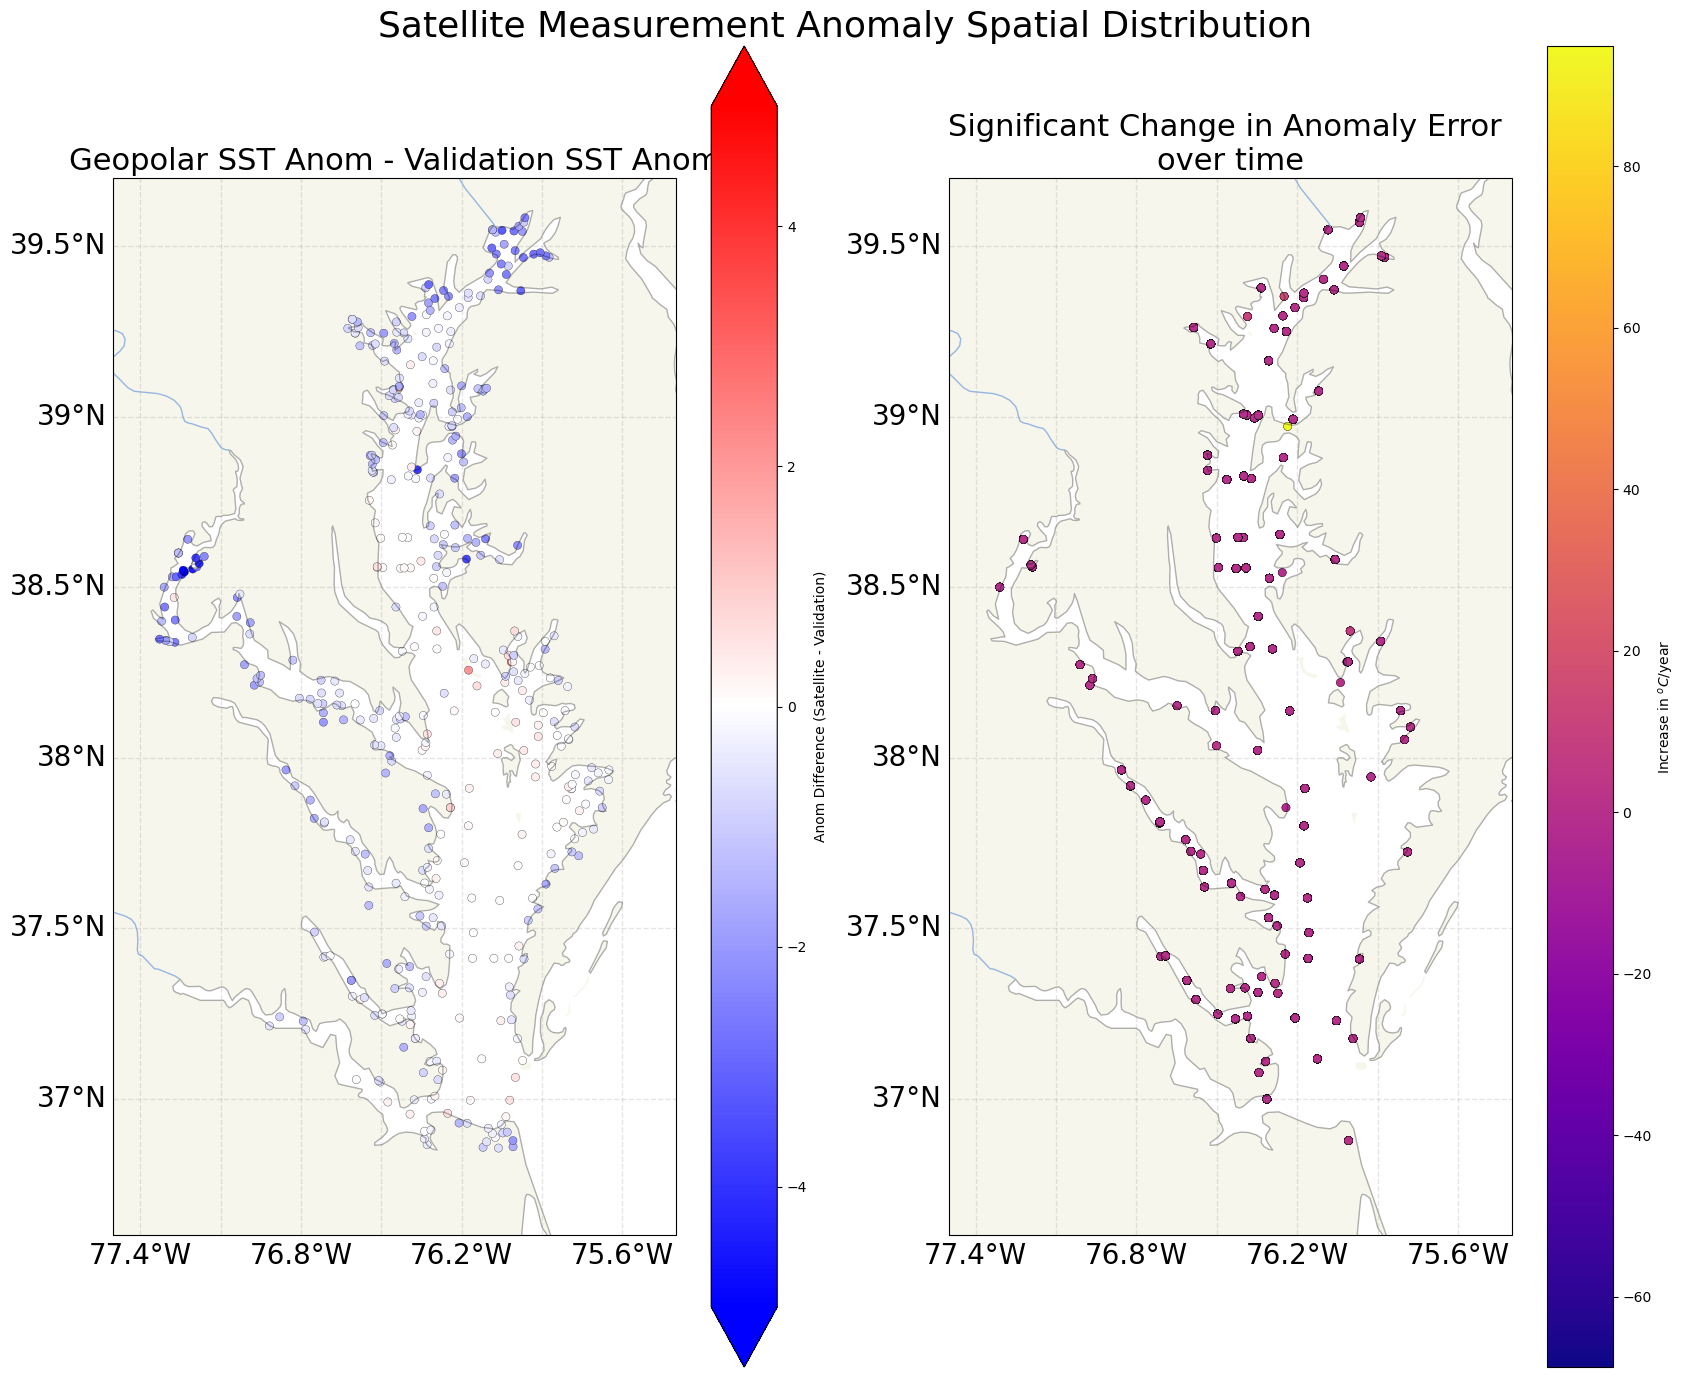

In [62]:
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(17, 14)
# fig.tight_layout()
fig.suptitle('Satellite Measurement Anomaly Spatial Distribution', size=26)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

for ax in axes.flatten():
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    # ax.coastlines()
    # Put a background image on for nice sea rendering.
    # ax.stock_img()

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}

# Add mean error
temps_mean_gpd.plot(ax=axes[0], column='geopolar_diff', markersize=35, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 
                                 'extend': 'both'}, 
                    vmin=-5, vmax=5, edgecolor='black', linewidth=0.2)
axes[0].set_title('Geopolar SST Anom - Validation SST Anom', size=22)

# Add long term trend slope
# Can't get pandas to show nan values. Maybe set to 0 then change colormap?
stats_gpd.plot(ax=axes[1], column='slope', markersize=35, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Increase in $^oC$/year"}, 
                    edgecolor='black', linewidth=0.2)
axes[1].set_title('Significant Change in Anomaly Error \nover time', size=22)

plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/map_distribution_statistics_shorter.png'), 
                dpi=400, bbox_inches='tight')

## Hovm&#246;ller Plot for Seasonality of Error



In [116]:
def create_hovmoller_matrix(temps: pd.DataFrame, satellite_name: str) -> pd.DataFrame:
    """
    temps - pandas dataframe of ...
    satellite_name
    """
    temps = temps.set_index(pd.to_datetime(temps['SampleDate']))
    temps = temps.resample('M').mean()
    
    temps = temps[[satellite_name + '_err']]
    
    temps['month'] = temps.index.month
    temps['year'] = temps.index.year
    
    matrix = temps.pivot(index='year', columns='month')
    
    return matrix

In [117]:
# wq_sst_mur = wq_sst[~wq_sst.mur_err.isnull()]
# wq_sst_gp = wq_sst[~wq_sst.geopolar_err.isnull()]

In [118]:
matrix_geop = create_hovmoller_matrix(wq_sst[~wq_sst.geopolar_err.isnull()], 'geopolar')
matrix_mur = create_hovmoller_matrix(wq_sst[~wq_sst.mur_err.isnull()], 'mur')

/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_778/3455120612.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temps = temps.resample('M').mean()
/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_778/3455120612.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temps = temps.resample('M').mean()


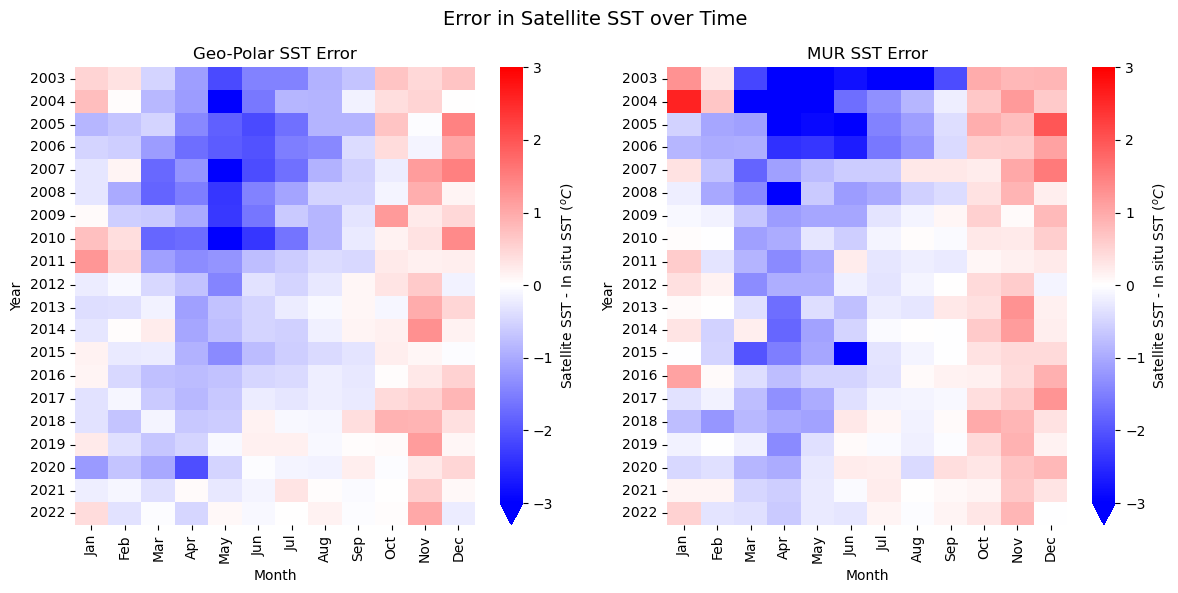

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
fig.suptitle('Error in Satellite SST over Time', size=14)

vmin, vmax = -3, 3
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 
          'Oct', 'Nov', 'Dec']

bwr_badgrey = plt.cm.get_cmap("bwr").copy()
bwr_badgrey.set_bad('grey')

sns.heatmap(matrix_geop, ax=ax1, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite SST - In situ SST ($^oC$)', 'extend': 'min'})
ax1.set_xticklabels(months, rotation=90)
ax1.set_xlabel('Month')
ax1.set_ylabel('Year')
ax1.set_title('Geo-Polar SST Error')

# # Create a Rectangle patch
# rect = patches.Rectangle((3, 2021), 40, 1000, linewidth=10, edgecolor='black', facecolor='black')

# # Add the patch to the Axes
# ax1.add_patch(rect)

# Format the colorbar
# cmap = plt.cm.twilight
# norm = matplotlib.colors.BoundaryNorm(range(1, 15), cmap.N)
# sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
# colors=[]
# for i in range(12):
#     if geo_pvals.iloc[i] > 0.05:
#         # append light grey if the trend is not significant
#         colors.append((0.878, 0.878, 0.878, 1))
#     else:
#         colors.append(sm.to_rgba(i+1))

sns.heatmap(matrix_mur, ax=ax2, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite SST - In situ SST ($^oC$)', 'extend': 'min'})
ax2.set_xticklabels(months, rotation=90)
ax2.set_xlabel('Month')
ax2.set_ylabel('Year')
ax2.set_title('MUR SST Error')


plt.tight_layout()
SAVE_FIGS = True
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures/supplemental_material/sst_hovmoller_error.png'), 
                dpi=350, 
                bbox_inches='tight')

Create Geo-Polar SST Hovemoller plot

In [128]:
matrix_geop.min()

              month
geopolar_err  1       -1.179006
              2       -0.986043
              3       -1.821150
              4       -2.083896
              5       -3.728098
              6       -2.343986
              7       -1.678226
              8       -1.387369
              9       -0.879355
              10      -0.212752
              11      -0.120971
              12      -0.215066
dtype: float64

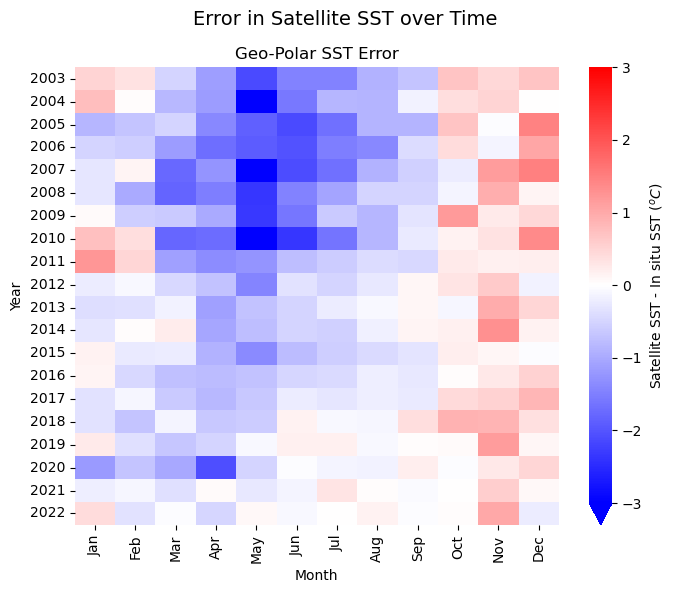

In [133]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 6)
fig.suptitle('Error in Satellite SST over Time', size=14)

vmin, vmax = -3, 3
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 
          'Oct', 'Nov', 'Dec']

bwr_badgrey = plt.cm.get_cmap("bwr").copy()
bwr_badgrey.set_bad('grey')

sns.heatmap(matrix_geop, ax=ax, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite SST - In situ SST ($^oC$)', 'extend': 'min'})
ax.set_xticklabels(months, rotation=90)
ax.set_xlabel('Month')
ax.set_ylabel('Year')
ax.set_title('Geo-Polar SST Error')

plt.tight_layout()
SAVE_FIGS = True
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures/supplemental_material/sst_hovmoller_error_geopolar.png'), 
                dpi=350, 
                bbox_inches='tight')

## Delete all below

### Quantifying Long Term trend by month

In [73]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(20),
                                                                     matrix_geop.mean(axis=1))

print('Geopolar: slope', slope.round(3), 'deg C per year', 'intercept', intercept, 'r squared', r_value**2, 'p_value', p_value)

Geopolar: slope 0.041 deg C per year intercept -0.6049768747510146 r squared 0.6659353578688084 p_value 1.1499917947695823e-05


In [74]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(20),
    matrix_mur.mean(axis=1))

print('MUR: slope', slope.round(3), 'deg C per year', 'intercept', intercept, 'r squared', r_value**2, 'p_value', p_value)

MUR: slope 0.063 deg C per year intercept -0.8531990146923916 r squared 0.5920944421655238 p_value 7.297419456249691e-05


In [75]:
def linearregression(row):
    _, _, r_value, p_value, _ = scipy.stats.linregress(range(20), row)
    row['p_value'] = p_value
    # return pd.DataFrame({'p_value': p_value, 'other': 0})
    return p_value

In [76]:
def significant_slopes(row):
    slope, _, r_value, p_value, _ = scipy.stats.linregress(range(20), row)
    # if p_value > 0.05:
    #     slope = np.nan
    # return pd.DataFrame({'p_value': p_value, 'other': 0})
    return slope

In [77]:
geo_pvals = matrix_geop.apply(linearregression, axis=0)
geo_slope = matrix_geop.apply(significant_slopes, axis=0)

In [78]:
mur_pvals = matrix_mur.apply(linearregression, axis=0)
mur_slope = matrix_mur.apply(significant_slopes, axis=0)

In [79]:
geo_pvals.index = geo_pvals.index.droplevel(0)
mur_pvals.index = mur_pvals.index.droplevel(0)

geo_slope.index = geo_slope.index.droplevel(0)
mur_slope.index = mur_slope.index.droplevel(0)

In [80]:
all_pvals = pd.concat([geo_pvals, mur_pvals], axis=1, keys=['geopolar', 'mur'])
all_slopes = pd.concat([geo_slope, mur_slope], axis=1, keys=['geopolar', 'mur'])

In [81]:
geo_slope = pd.DataFrame(geo_slope)
geo_slope['significant'] = geo_slope > 0.05

In [82]:
geo_slope = geo_slope.rename({0: 'error_slope'}, axis=1)

In [83]:
geo_slope

error_slope  significant
month                          
1        -0.016449        False
2        -0.013679        False
3         0.041951        False
4         0.042326        False
5         0.156803         True
6         0.122671         True
7         0.093700         True
8         0.062230         True
9         0.037744        False
10       -0.018993        False
11        0.021878        False
12       -0.040984        False

In [84]:
geo_pvals

month
1     4.766117e-01
2     3.962000e-01
3     6.323508e-02
4     2.274096e-02
5     1.014911e-06
6     1.022042e-06
7     5.866144e-07
8     2.472164e-07
9     6.871329e-04
10    1.880164e-01
11    1.918230e-01
12    3.976645e-02
dtype: float64

### Ploting Temporal Trends

In [86]:
cmap = plt.cm.twilight
norm = matplotlib.colors.BoundaryNorm(range(1, 15), cmap.N)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

In [87]:
# import matplotlib.patches as patches

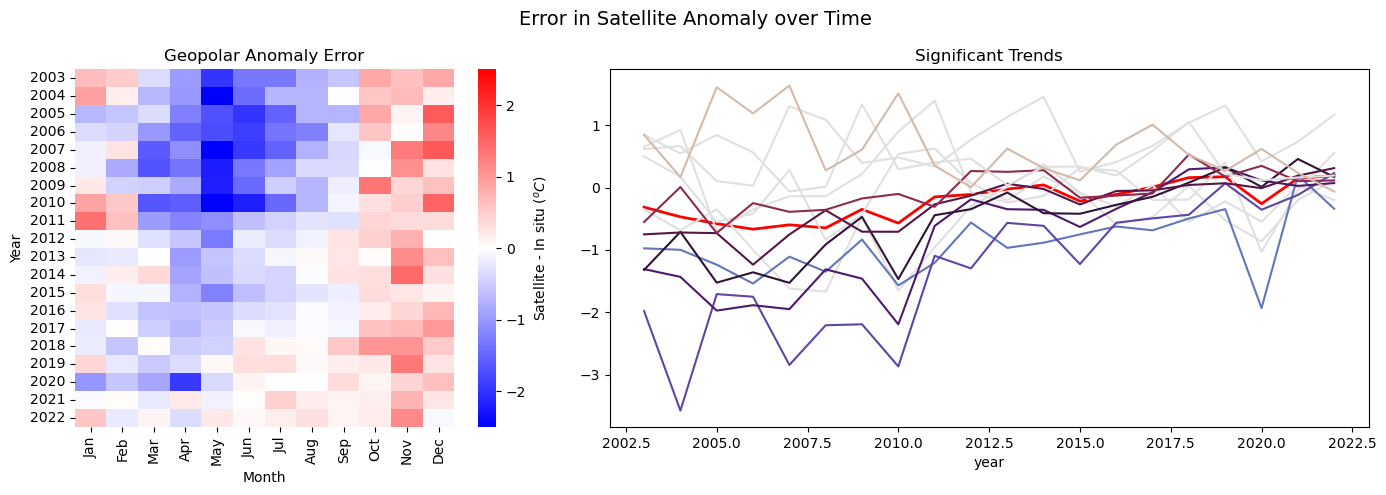

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1.6]})
fig.suptitle('Error in Satellite Anomaly over Time', size=14)

bwr_badgrey = plt.cm.get_cmap("bwr").copy()
bwr_badgrey.set_bad('grey')

sns.heatmap(matrix_geop, ax=ax1, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite - In situ ($^oC$)'})
ax1.set_xticklabels(months, rotation=90)
ax1.set_xlabel('Month')
ax1.set_ylabel('Year')

# # Create a Rectangle patch
# rect = patches.Rectangle((3, 2021), 40, 1000, linewidth=10, edgecolor='black', facecolor='black')

# # Add the patch to the Axes
# ax1.add_patch(rect)

# Format the colorbar
cmap = plt.cm.twilight
norm = matplotlib.colors.BoundaryNorm(range(1, 15), cmap.N)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
colors=[]
for i in range(12):
    if geo_pvals.iloc[i] > 0.05:
        # append light grey if the trend is not significant
        colors.append((0.878, 0.878, 0.878, 1))
    else:
        colors.append(sm.to_rgba(i+1))

matrix_geop.mean(axis=1).plot(ax=ax2, color='red', linewidth=2, label='mean')
matrix_geop.plot(ax=ax2, color=colors, legend=False)

ax1.set_title('Geopolar Anomaly Error')
ax2.set_title('Significant Trends')


plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/hovmoller_error_withmonths.png'), 
                dpi=350, bbox_inches='tight')

In [89]:
matrix_geop.min().min(), matrix_geop.max().max()

(-3.578098483615452, 1.6351247382886482)

In [97]:
matrix_mur.min().min(), matrix_mur.max().max()

(-6.1529295872490195, 2.7471384684244793)

## Error Histogram

**TODO:** What is the point of the plot? Is it to show that the distribtuion is just a bit wider/narrow in each satellite? Or is it to show that one outlier?

In [39]:
mur_mean, mur_std = wq_sst_mur.mur_diff.mean(), wq_sst_mur.mur_diff.std()
gp_mean, gp_std = wq_sst_gp.geopolar_diff.mean(), wq_sst_gp.geopolar_diff.std()

In [40]:
mur_skew, mur_kurtosis = scipy.stats.skew(wq_sst_mur.mur_diff), scipy.stats.kurtosis(wq_sst_mur.mur_diff)
gp_skew, gp_kurtosis = scipy.stats.skew(wq_sst_gp.geopolar_diff), scipy.stats.kurtosis(wq_sst_gp.geopolar_diff)

In [41]:
print('mur skew / kurtosis: ', mur_skew, mur_kurtosis)
print('geopolar skew / kurtosis: ', gp_skew, gp_kurtosis)

mur skew / kurtosis:  -1.880341587677962 10.13949413757137
geopolar skew / kurtosis:  -1.0408460932054557 6.879465342358197


In [42]:
mur_mean, mur_std

(-0.39130512331257516, 1.7685256176391038)

In [43]:
gp_mean, gp_std

(-0.37111893989183925, 1.5182878109568065)

**TODO** Can I justify this times 2000 thing?

In [44]:
# Normal Distributions
x_norm = np.linspace(-10, 10, 100)
mur_norm = [stats.norm.pdf(x, mur_mean, mur_std)*2000 for x in x_norm]
gp_norm = [stats.norm.pdf(x, gp_mean, gp_std)*2000 for x in x_norm]
# stats.norm.pdf(x, mu, sigma)

In [45]:
# fig, (ax1, ax2) = plt.subplots(1, 2)

# fig.set_size_inches(8, 3)
# fig.suptitle('Histogram of SST Anomaly for MUR and Geopolar Blended')

# wq_sst_mur.geopolar_diff.hist(ax = ax2, bins=75)
# ax2.set_title('mur value' + ' Histogram')
# # Plot normal curve
# ax2.plot(x_norm, gp_norm, linewidth=0.8)
# ax2.set_yscale('log')

# wq_sst_gp.mur_diff.hist(ax = ax1, bins=75, log=True)
# ax1.set_title('geopolar value' + ' Histogram')
# ax1.set_ylabel('Count')
# ax1.plot(x_norm, mur_norm, linewidth=0.8)
# ax1.set_yscale('log')

# for ax in (ax1, ax2):
#     # label x axis
#     ax.set_xlabel('Temperature Error ($^oC$)')
#     # standardize axes
#     # ax.set_xlim([-8, 23])
#     ax.set_ylim([0.9, 1000])
#     ax.set_xlim([-20, 26])
#     # ax.set_ylim([0.8, 10000])
#     # WHAT TO DO ABOUT GRIDLINES
#     # add minor ticks
#     # ax.xaxis.grid(which='major', color='#DDDDDD', linewidth=0.8)
#     # # Show the minor grid as well. Style it in very light gray as a thin,
#     # # dotted line.
#     ax.xaxis.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
#     ax.xaxis.set_minor_locator(AutoMinorLocator())
#     ax.grid(False)
#     # ax.axvline(0, color='black')

# plt.tight_layout()
# if SAVE_FIGS:
#     plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/errors_histogram.png'), 
#                 dpi=400, bbox_inches='tight')

## Spatial Plots

**TODO**: figure out if there is a way to improve the resolution of the coastline, so it doesn't look like there are datapoints being taken on land.

**TODO**: Awkward spacing

Below: There are 49 anomaly validation stations spread across the bay

In [43]:
# temps_mean_gpd.groupby(['Latitude', 'Longitude']).groups

<AxesSubplot: >

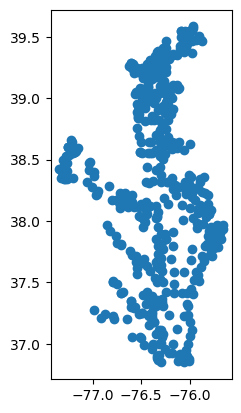

In [44]:
temps_mean_gpd.plot()

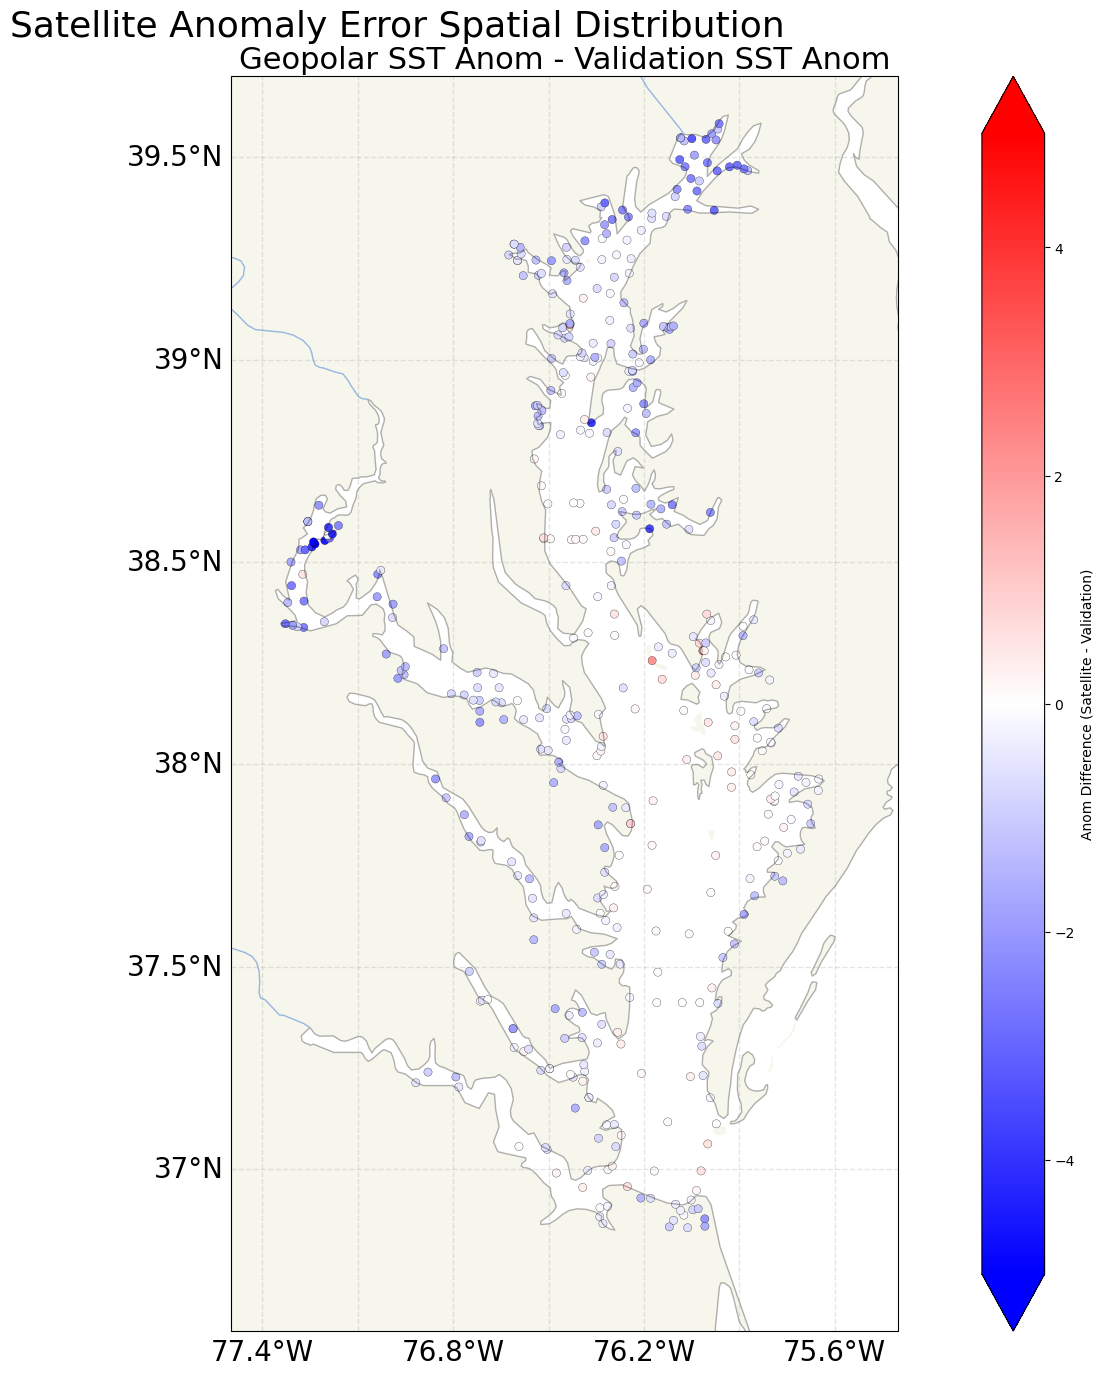

In [63]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(17, 14)
# fig.tight_layout()
fig.suptitle('Satellite Anomaly Error Spatial Distribution', size=26)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

# Add background features
ax.add_feature(cfeature.COASTLINE, alpha=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
# ax.coastlines()
# Put a background image on for nice sea rendering.
# ax.stock_img()

ax.set_extent([-77.5, -75.4, 36.6, 39.7])

# Add and format gridlines. Remove top and right labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.top_labels, gl.right_labels = False, False
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Add mean error
temps_mean_gpd.plot(ax=ax, column='geopolar_diff', markersize=35, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 
                                 'extend': 'both'}, 
                    vmin=-5, vmax=5, edgecolor='black', linewidth=0.2)
ax.set_title('Geopolar SST Anom - Validation SST Anom', size=22)


plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/map_distribution_statistics_shorter.png'), 
                dpi=400, bbox_inches='tight')

In [64]:
# SAVE_FIGS = True

In [65]:
temps_mean_gpd.mur_diff.min()

-10.552001953125

Walking through p values:

Question: Does the size of the anomaly value vary over time?
Hypothesis: ...

In [67]:
# wq_sst.groupby(['Latitude', 'Longitude']).apply(trend_calc)

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(6, 6)
# fig.suptitle('Error in Satellite Anomaly over Time', size=14)

# bwr_badgrey = plt.cm.get_cmap("bwr").copy()
# bwr_badgrey.set_bad('grey')

# sns.heatmap(matrix_geop, ax=ax, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
#             cbar_kws={'label': 'Satellite Anom - In situ Anom ($^oC$)'})
# ax.set_xticklabels(months, rotation=90)
# ax.set_xlabel('Month')
# ax.set_ylabel('Year')

# matrix_geop.mean(axis=1).plot(ax=ax2, color='red', linewidth=2, label='mean')
# # matrix_geop.plot(ax=ax2, color=colors, legend=False)

# ax1.set_title('Geopolar Anomaly Error')
# # ax2.set_title('Significant Trends')


# plt.tight_layout()
# if SAVE_FIGS:
#     plt.savefig(os.path.join(REPO_ROOT, 'figures/validation_analysis/hovmoller_error.png'), 
#                 dpi=350, 
#                 bbox_inches='tight')